# Experiment 1

## Data Prep

In [281]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override()

df = pdr.get_data_yahoo("AAPL")

[*********************100%%**********************]  1 of 1 completed


In [282]:
reversed_df = df.iloc[::-1]

In [283]:
import numpy as np

def create_sequences(data, seq_length, prediction_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-prediction_length+1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length+prediction_length-1][4]  
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [284]:
# Split the data
split_fraction = 0.8
split = int(split_fraction * len(df))

# Split data into forward and backward sets
X_fwd = df.values
y_fwd = df.iloc[:, 4].values  # target is at index 4

X_bkwd = reversed_df.values
y_bkwd = reversed_df.iloc[:, 4].values

X_train_fwd, X_test_fwd = X_fwd[:split], X_fwd[split:]
y_train_fwd, y_test_fwd = y_fwd[:split], y_fwd[split:]

X_train_bkwd, X_test_bkwd = X_bkwd[:split], X_bkwd[split:]
y_train_bkwd, y_test_bkwd = y_bkwd[:split], y_bkwd[split:]

In [285]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler_fwd = MinMaxScaler()
X_train_fwd_scaled = scaler_fwd.fit_transform(X_train_fwd)
X_test_fwd_scaled = scaler_fwd.transform(X_test_fwd)

scaler_bkwd = MinMaxScaler()
X_train_bkwd_scaled = scaler_bkwd.fit_transform(X_train_bkwd)
X_test_bkwd_scaled = scaler_bkwd.transform(X_test_bkwd)

In [286]:
# Check the mean and standard deviation of each feature
mean_values = np.mean(X_test_bkwd_scaled, axis=0)
std_dev_values = np.std(X_test_bkwd_scaled, axis=0)

# Print the mean and standard deviation for each feature
for i, (mean, std_dev) in enumerate(zip(mean_values, std_dev_values)):
    print(f"Feature {i+1}: Mean={mean}, Std Dev={std_dev}")

Feature 1: Mean=0.00038839944368337204, Std Dev=0.0006008990893267693
Feature 2: Mean=0.0003849151187631694, Std Dev=0.0006074484037314789
Feature 3: Mean=0.0003797480617108095, Std Dev=0.0005919520372806078
Feature 4: Mean=0.00038488021140914235, Std Dev=0.0006010237839240249
Feature 5: Mean=0.0002581543471827665, Std Dev=0.0004702166127424272
Feature 6: Mean=0.021310974728610717, Std Dev=0.018887805922950373


In [292]:
# Create sequences for training data
seq_length = 5
prediction_length = 1
X_train_fwd_seq, y_train_fwd_seq = create_sequences(X_train_fwd_scaled, seq_length, prediction_length)
X_train_bkwd_seq, y_train_bkwd_seq = create_sequences(X_train_bkwd_scaled, seq_length, prediction_length)

# Create sequences for test data
X_test_fwd_seq, y_test_fwd_seq = create_sequences(X_test_fwd_scaled, seq_length, prediction_length)
X_test_bkwd_seq, y_test_bkwd_seq = create_sequences(X_test_bkwd_scaled, seq_length, prediction_length)

In [293]:
import torch 
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch Datasets
batch_size = 64

#Forward
train_data_fwd = TensorDataset(torch.Tensor(X_train_fwd_seq), torch.Tensor(y_train_fwd_seq))
train_loader_fwd = DataLoader(train_data_fwd, shuffle=True, batch_size=batch_size)

test_data_fwd = TensorDataset(torch.Tensor(X_test_fwd_seq), torch.Tensor(y_test_fwd_seq))
test_loader_fwd = DataLoader(test_data_fwd, shuffle=False, batch_size=batch_size)

#Backward
train_data_bkwd = TensorDataset(torch.Tensor(X_train_bkwd_seq), torch.Tensor(y_train_bkwd_seq))
train_loader_bkwd = DataLoader(train_data_bkwd, shuffle=True, batch_size=batch_size)

test_data_bkwd = TensorDataset(torch.Tensor(X_test_bkwd_seq), torch.Tensor(y_test_bkwd_seq))
test_loader_bkwd = DataLoader(test_data_bkwd, shuffle=False, batch_size=batch_size)

## Simple RNN

### Model Definition

In [311]:
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [312]:
def training_loop(num_epochs, device, optimizer, criterion, model, train_loader, test_loader):
    train_loss_values = []
    test_loss_values = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels.unsqueeze(-1))
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_values.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')
        
        # Testing phase
        model.eval() 
        total_test_loss = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                
                # Calculate loss
                loss = criterion(outputs, labels.unsqueeze(-1))
                total_test_loss += loss.item()
        
        avg_test_loss = total_test_loss / len(test_loader)
        test_loss_values.append(avg_test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}')
        
    return train_loss_values, test_loss_values


### Forward and Backward Training

Running on CPU
Epoch [1/50], Train Loss: 0.0373
Epoch [1/50], Test Loss: 6.7167
Epoch [2/50], Train Loss: 0.0005
Epoch [2/50], Test Loss: 6.3173
Epoch [3/50], Train Loss: 0.0003
Epoch [3/50], Test Loss: 5.9225
Epoch [4/50], Train Loss: 0.0002
Epoch [4/50], Test Loss: 5.6018
Epoch [5/50], Train Loss: 0.0002
Epoch [5/50], Test Loss: 5.3028
Epoch [6/50], Train Loss: 0.0001
Epoch [6/50], Test Loss: 5.0528
Epoch [7/50], Train Loss: 0.0001
Epoch [7/50], Test Loss: 4.8531
Epoch [8/50], Train Loss: 0.0001
Epoch [8/50], Test Loss: 4.6906
Epoch [9/50], Train Loss: 0.0001
Epoch [9/50], Test Loss: 4.5291
Epoch [10/50], Train Loss: 0.0001
Epoch [10/50], Test Loss: 4.4032
Epoch [11/50], Train Loss: 0.0000
Epoch [11/50], Test Loss: 4.3178
Epoch [12/50], Train Loss: 0.0000
Epoch [12/50], Test Loss: 4.2436
Epoch [13/50], Train Loss: 0.0000
Epoch [13/50], Test Loss: 4.1924
Epoch [14/50], Train Loss: 0.0000
Epoch [14/50], Test Loss: 4.1554
Epoch [15/50], Train Loss: 0.0000
Epoch [15/50], Test Loss: 4.120

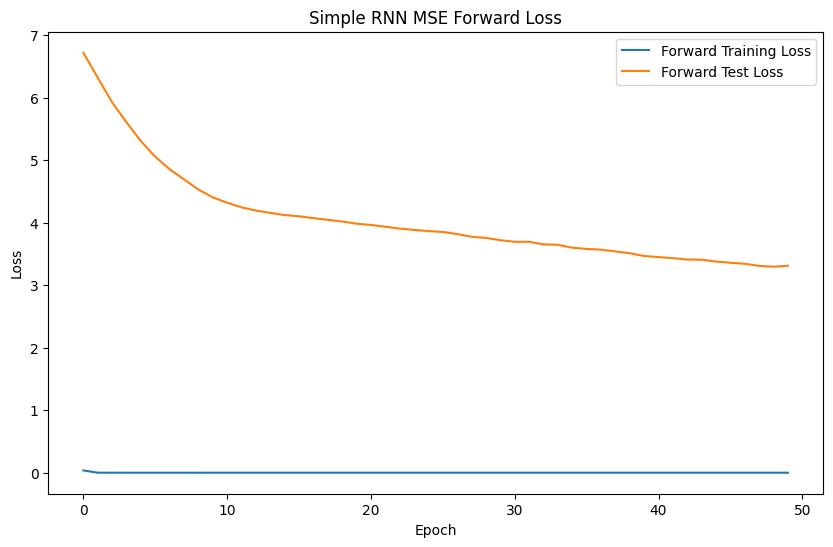

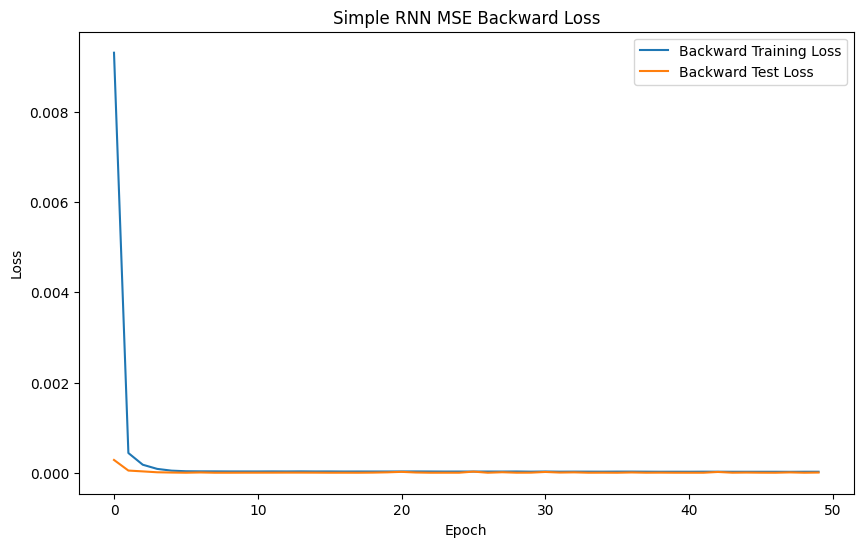

In [313]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("Running on GPU")
else: print("Running on CPU")

criterion = nn.MSELoss()
num_epochs = 50

# Forward Model Initialization and Training 
model_fwd = SimpleRNN(input_size=6, hidden_size=20, output_size=1).to(device)
optimizer_fwd = optim.Adam(model_fwd.parameters(), lr=0.001)

loss_values_fwd_train, loss_values_fwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer_fwd,
    criterion=criterion,
    model=model_fwd,
    train_loader=train_loader_fwd,
    test_loader=test_loader_fwd
              )

# Backward Model Initialization and Training
model_bkwd = SimpleRNN(input_size=6, hidden_size=20, output_size=1).to(device)
optimizer_bkwd = optim.Adam(model_bkwd.parameters(), lr=0.001)

loss_values_bkwd_train, loss_values_bkwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer_bkwd,
    criterion=criterion,
    model=model_bkwd,
    train_loader=train_loader_bkwd,
    test_loader=test_loader_bkwd
              )

plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd_train, label='Forward Training Loss')
plt.plot(loss_values_fwd_test, label='Forward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Simple RNN MSE Forward Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(loss_values_bkwd_train, label='Backward Training Loss')
plt.plot(loss_values_bkwd_test, label='Backward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Simple RNN MSE Backward Loss')
plt.legend()
plt.show()

## LSTM

In [271]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

Epoch [1/50], Train Loss: 0.0086
Epoch [1/50], Test Loss: 7.0134
Epoch [2/50], Train Loss: 0.0001
Epoch [2/50], Test Loss: 6.4753
Epoch [3/50], Train Loss: 0.0001
Epoch [3/50], Test Loss: 6.2054
Epoch [4/50], Train Loss: 0.0001
Epoch [4/50], Test Loss: 6.0363
Epoch [5/50], Train Loss: 0.0001
Epoch [5/50], Test Loss: 5.8761
Epoch [6/50], Train Loss: 0.0001
Epoch [6/50], Test Loss: 5.7502
Epoch [7/50], Train Loss: 0.0001
Epoch [7/50], Test Loss: 5.6128
Epoch [8/50], Train Loss: 0.0001
Epoch [8/50], Test Loss: 5.5069
Epoch [9/50], Train Loss: 0.0001
Epoch [9/50], Test Loss: 5.3810
Epoch [10/50], Train Loss: 0.0000
Epoch [10/50], Test Loss: 5.2314
Epoch [11/50], Train Loss: 0.0000
Epoch [11/50], Test Loss: 5.1729
Epoch [12/50], Train Loss: 0.0000
Epoch [12/50], Test Loss: 5.0452
Epoch [13/50], Train Loss: 0.0000
Epoch [13/50], Test Loss: 4.9245
Epoch [14/50], Train Loss: 0.0000
Epoch [14/50], Test Loss: 4.8918
Epoch [15/50], Train Loss: 0.0000
Epoch [15/50], Test Loss: 4.8525
Epoch [16/50]

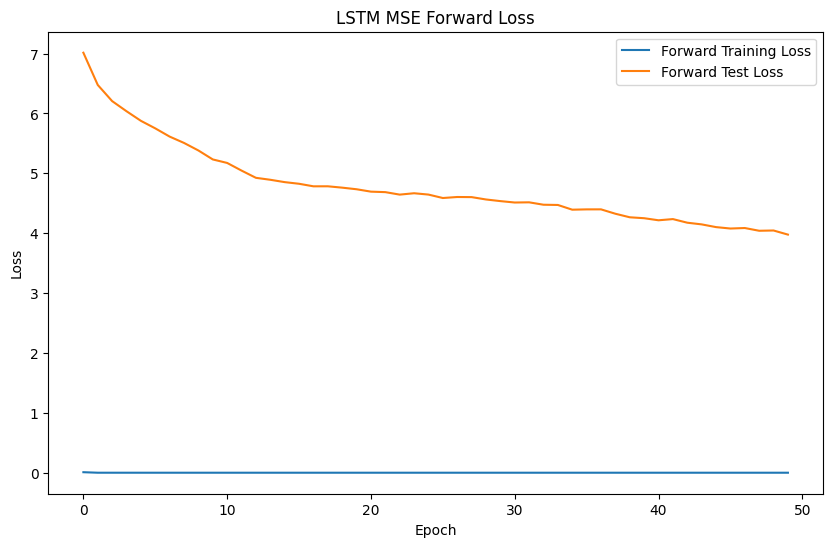

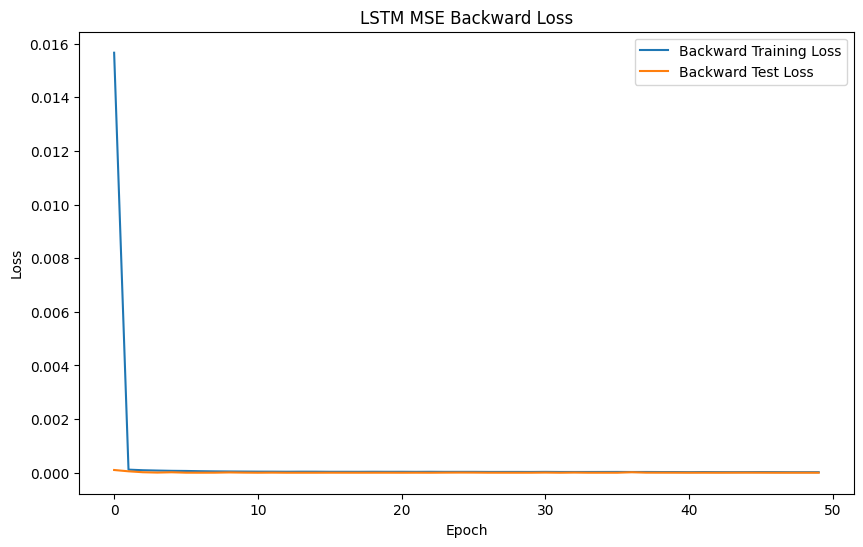

In [314]:
# LSTM Model Initialization and Training 

#Forward
lstm_model = LSTMModel(input_size=6, hidden_size=20, output_size=1).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

loss_values_fwd_train, loss_values_fwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=lstm_model,
    train_loader=train_loader_fwd, 
    test_loader=test_loader_fwd     
)

#Backward
lstm_model = LSTMModel(input_size=6, hidden_size=20, output_size=1).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

loss_values_bkwd_train, loss_values_bkwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=lstm_model,
    train_loader=train_loader_bkwd, 
    test_loader=test_loader_bkwd
)  

plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd_train, label='Forward Training Loss')
plt.plot(loss_values_fwd_test, label='Forward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM MSE Forward Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(loss_values_bkwd_train, label='Backward Training Loss')
plt.plot(loss_values_bkwd_test, label='Backward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM MSE Backward Loss')
plt.legend()
plt.show()

## GRU

In [315]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate GRU
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

Epoch [1/50], Train Loss: 0.0077
Epoch [1/50], Test Loss: 4.9541
Epoch [2/50], Train Loss: 0.0001
Epoch [2/50], Test Loss: 4.7606
Epoch [3/50], Train Loss: 0.0001
Epoch [3/50], Test Loss: 4.6579
Epoch [4/50], Train Loss: 0.0000
Epoch [4/50], Test Loss: 4.5717
Epoch [5/50], Train Loss: 0.0000
Epoch [5/50], Test Loss: 4.5187
Epoch [6/50], Train Loss: 0.0000
Epoch [6/50], Test Loss: 4.4478
Epoch [7/50], Train Loss: 0.0000
Epoch [7/50], Test Loss: 4.4106
Epoch [8/50], Train Loss: 0.0000
Epoch [8/50], Test Loss: 4.3581
Epoch [9/50], Train Loss: 0.0000
Epoch [9/50], Test Loss: 4.2988
Epoch [10/50], Train Loss: 0.0000
Epoch [10/50], Test Loss: 4.2528
Epoch [11/50], Train Loss: 0.0000
Epoch [11/50], Test Loss: 4.2096
Epoch [12/50], Train Loss: 0.0000
Epoch [12/50], Test Loss: 4.1515
Epoch [13/50], Train Loss: 0.0000
Epoch [13/50], Test Loss: 4.0976
Epoch [14/50], Train Loss: 0.0000
Epoch [14/50], Test Loss: 4.0556
Epoch [15/50], Train Loss: 0.0000
Epoch [15/50], Test Loss: 4.0093
Epoch [16/50]

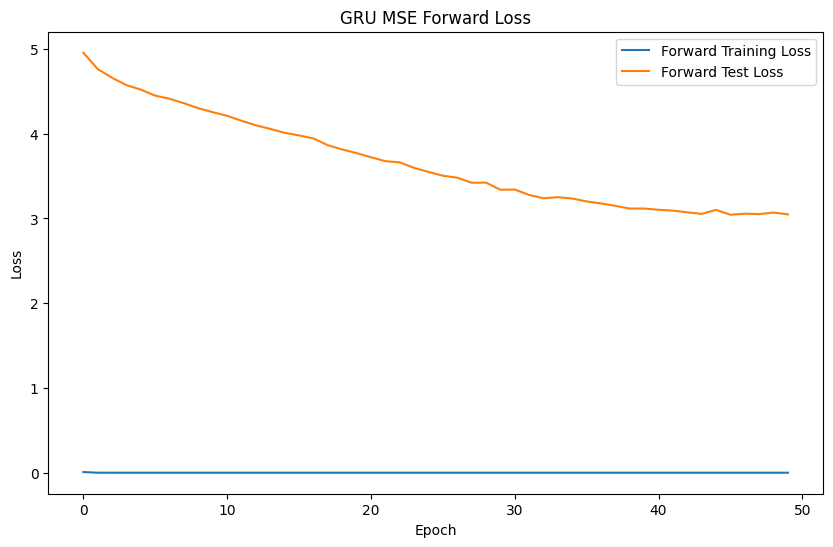

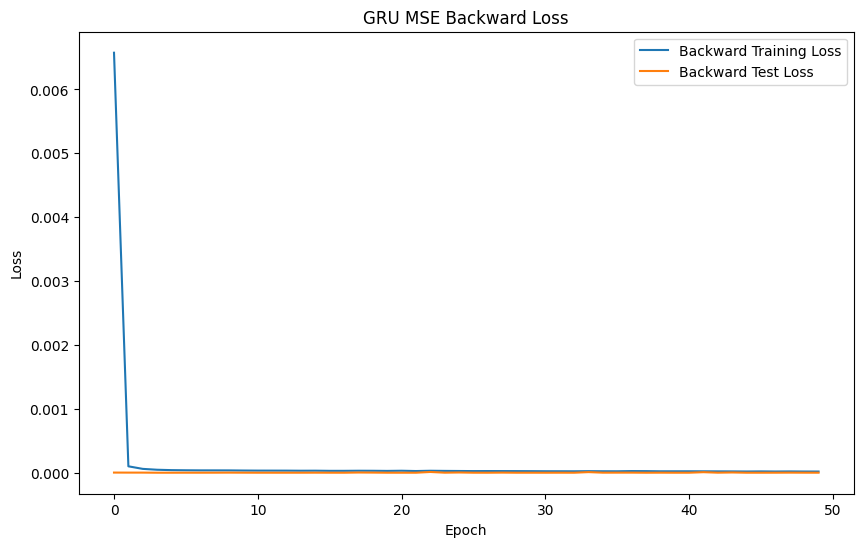

In [316]:
# LSTM Model Initialization and Training 

#Forward
lstm_model = GRUModel(input_size=6, hidden_size=20, output_size=1).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

loss_values_fwd_train, loss_values_fwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=lstm_model,
    train_loader=train_loader_fwd, 
    test_loader=test_loader_fwd     
)

#Backward
lstm_model = GRUModel(input_size=6, hidden_size=20, output_size=1).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

loss_values_bkwd_train, loss_values_bkwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=lstm_model,
    train_loader=train_loader_bkwd, 
    test_loader=test_loader_bkwd
)  

plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd_train, label='Forward Training Loss')
plt.plot(loss_values_fwd_test, label='Forward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRU MSE Forward Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(loss_values_bkwd_train, label='Backward Training Loss')
plt.plot(loss_values_bkwd_test, label='Backward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRU MSE Backward Loss')
plt.legend()
plt.show()

## Transformer

### Model Definition

In [317]:
import torch
import torch.nn as nn
import math

class TransformerModel(nn.Module):
    def __init__(self, input_size, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.encoder = nn.Linear(input_size, input_size) 
        self.pos_encoder = PositionalEncoding(input_size, dropout)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, 
                                       dim_feedforward=nhid, dropout=dropout),
            num_layers=nlayers)
        self.decoder = nn.Linear(input_size, 1)  
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.encoder.bias.data.zero_()
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.encoder(src)  
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])  # Decode the last output of the sequence
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


In [318]:
# Parameters for the model
input_size = 6  # same as seq_length
nhead = 2
nhid = 64
nlayers = 2
dropout = 0.2
num_epochs = 50

model = TransformerModel(input_size, nhead, nhid, nlayers, dropout).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


/Users/christopherguarino/anaconda3/envs/predictpast/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [319]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, test_loader, num_epochs):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Lists to store loss values for plotting
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  
        
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                val_loss = criterion(outputs.squeeze(), targets)
                total_test_loss += val_loss.item()
        
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss) 
        print(f'Epoch [{epoch + 1}/{num_epochs}]: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses 


In [320]:
def reset_weights(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()

### Forward and Backward Training

Epoch [1/50]: Train Loss: 0.0772, Test Loss: 12.1314
Epoch [2/50]: Train Loss: 0.0358, Test Loss: 10.8583
Epoch [3/50]: Train Loss: 0.0173, Test Loss: 10.1584
Epoch [4/50]: Train Loss: 0.0121, Test Loss: 9.6119
Epoch [5/50]: Train Loss: 0.0096, Test Loss: 9.5784
Epoch [6/50]: Train Loss: 0.0080, Test Loss: 9.4260
Epoch [7/50]: Train Loss: 0.0072, Test Loss: 9.3682
Epoch [8/50]: Train Loss: 0.0067, Test Loss: 9.3892
Epoch [9/50]: Train Loss: 0.0062, Test Loss: 9.3943
Epoch [10/50]: Train Loss: 0.0059, Test Loss: 9.4063
Epoch [11/50]: Train Loss: 0.0054, Test Loss: 9.3143
Epoch [12/50]: Train Loss: 0.0055, Test Loss: 9.2970
Epoch [13/50]: Train Loss: 0.0051, Test Loss: 9.2249
Epoch [14/50]: Train Loss: 0.0048, Test Loss: 9.1990
Epoch [15/50]: Train Loss: 0.0047, Test Loss: 9.2812
Epoch [16/50]: Train Loss: 0.0045, Test Loss: 9.2515
Epoch [17/50]: Train Loss: 0.0044, Test Loss: 9.3346
Epoch [18/50]: Train Loss: 0.0041, Test Loss: 9.2204
Epoch [19/50]: Train Loss: 0.0043, Test Loss: 9.3906

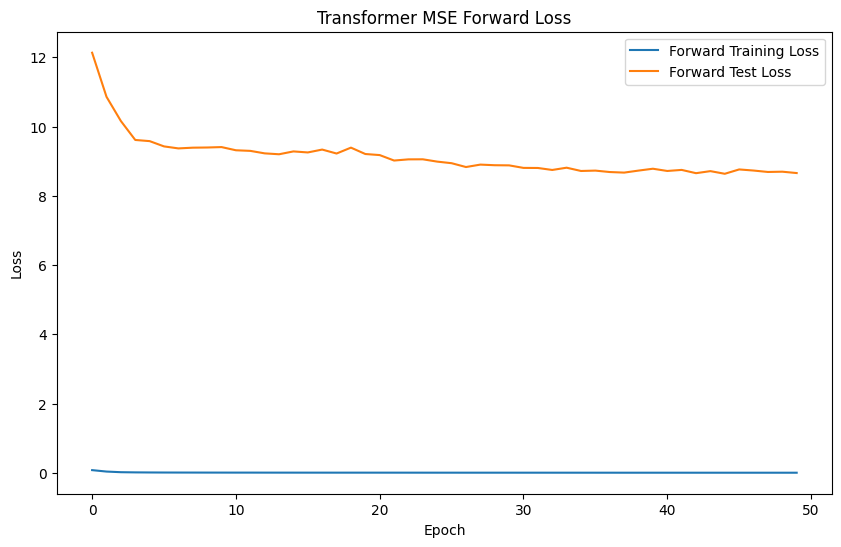

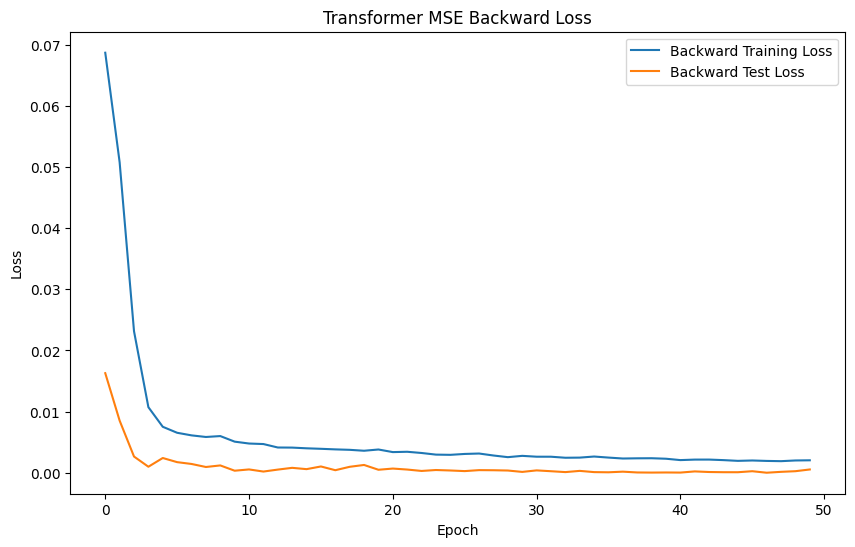

In [321]:
import matplotlib.pyplot as plt

model.apply(reset_weights) 
loss_values_fwd_train, loss_values_fwd_test = train_model(model, train_loader_fwd, test_loader_fwd, num_epochs)
model.apply(reset_weights) 
loss_values_bkwd_train, loss_values_bkwd_test = train_model(model, train_loader_bkwd, test_loader_bkwd, num_epochs)

plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd_train, label='Forward Training Loss')
plt.plot(loss_values_fwd_test, label='Forward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transformer MSE Forward Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(loss_values_bkwd_train, label='Backward Training Loss')
plt.plot(loss_values_bkwd_test, label='Backward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transformer MSE Backward Loss')
plt.legend()
plt.show()

### Sine Data to Troubleshoot

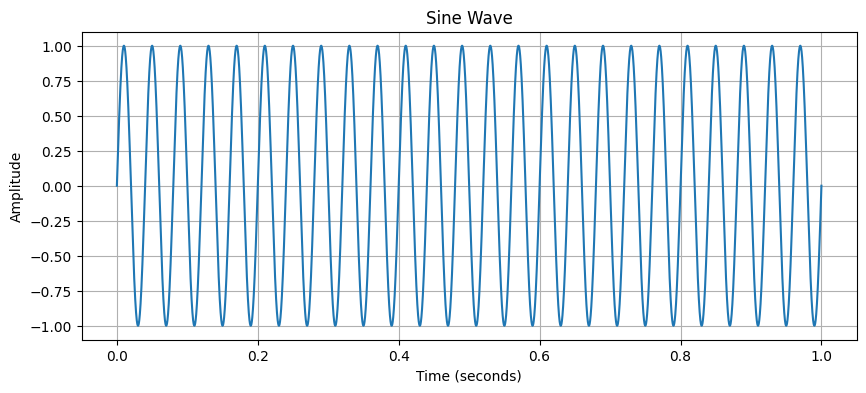

In [323]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
amplitude = 1       
frequency = 25      
num_points = 10000  
duration = 1      

# Generate time array (x values) from 0 to duration
x = np.linspace(0, duration, num_points)

# Generate Sine Wave, adjusting the formula to fit the frequency and duration
y = amplitude * np.sin(2 * np.pi * frequency * x / duration)

# Create DataFrame
sine_data = pd.DataFrame({
    'Time': x,
    'Amplitude': y
})

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(data['Time'], data['Amplitude'])
plt.title('Sine Wave')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



In [324]:
sine_data

,Time,Amplitude
0,0.0000,0.000000e+00
1,0.0001,1.570889e-02
2,0.0002,3.141390e-02
3,0.0003,4.711116e-02
4,0.0004,6.279679e-02
...,...,...
9995,0.9996,-6.279679e-02
9996,0.9997,-4.711116e-02
9997,0.9998,-3.141390e-02
9998,0.9999,-1.570889e-02


In [325]:
reversed_sine_data = sine_data.iloc[::-1]
reversed_sine_data

,Time,Amplitude
9999,1.0000,9.821934e-16
9998,0.9999,-1.570889e-02
9997,0.9998,-3.141390e-02
9996,0.9997,-4.711116e-02
9995,0.9996,-6.279679e-02
...,...,...
4,0.0004,6.279679e-02
3,0.0003,4.711116e-02
2,0.0002,3.141390e-02
1,0.0001,1.570889e-02


In [326]:
# Split the data
split_fraction = 0.8
split = int(split_fraction * len(sine_data))

# Split data into forward and backward sets
X_fwd = sine_data.values
y_fwd = sine_data.iloc[:, 1].values  

X_bkwd = reversed_sine_data.values
y_bkwd = reversed_sine_data.iloc[:, 1].values

X_train_fwd, X_test_fwd = X_fwd[:split], X_fwd[split:]
y_train_fwd, y_test_fwd = y_fwd[:split], y_fwd[split:]

X_train_bkwd, X_test_bkwd = X_bkwd[:split], X_bkwd[split:]
y_train_bkwd, y_test_bkwd = y_bkwd[:split], y_bkwd[split:]

In [327]:
import numpy as np

def create_sequences(data, seq_length, prediction_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-prediction_length+1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length+prediction_length-1][1]  
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [328]:
# Create sequences for training data
seq_length = 5
prediction_length = 1
X_train_fwd_seq, y_train_fwd_seq = create_sequences(X_train_fwd, seq_length, prediction_length)
X_train_bkwd_seq, y_train_bkwd_seq = create_sequences(X_train_bkwd, seq_length, prediction_length)

# Create sequences for test data
X_test_fwd_seq, y_test_fwd_seq = create_sequences(X_test_fwd, seq_length, prediction_length)
X_test_bkwd_seq, y_test_bkwd_seq = create_sequences(X_test_bkwd, seq_length, prediction_length)

In [329]:
import torch 
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch Datasets
batch_size = 64

#Forward
train_data_fwd = TensorDataset(torch.Tensor(X_train_fwd_seq), torch.Tensor(y_train_fwd_seq))
train_loader_fwd = DataLoader(train_data_fwd, shuffle=True, batch_size=batch_size)

test_data_fwd = TensorDataset(torch.Tensor(X_test_fwd_seq), torch.Tensor(y_test_fwd_seq))
test_loader_fwd = DataLoader(test_data_fwd, shuffle=False, batch_size=batch_size)

#Backward
train_data_bkwd = TensorDataset(torch.Tensor(X_train_bkwd_seq), torch.Tensor(y_train_bkwd_seq))
train_loader_bkwd = DataLoader(train_data_bkwd, shuffle=True, batch_size=batch_size)

test_data_bkwd = TensorDataset(torch.Tensor(X_test_bkwd_seq), torch.Tensor(y_test_bkwd_seq))
test_loader_bkwd = DataLoader(test_data_bkwd, shuffle=False, batch_size=batch_size)

Running on CPU
Epoch [1/100], Train Loss: 0.0216
Epoch [1/100], Test Loss: 0.0014
Epoch [2/100], Train Loss: 0.0004
Epoch [2/100], Test Loss: 0.0001
Epoch [3/100], Train Loss: 0.0001
Epoch [3/100], Test Loss: 0.0001
Epoch [4/100], Train Loss: 0.0001
Epoch [4/100], Test Loss: 0.0003
Epoch [5/100], Train Loss: 0.0001
Epoch [5/100], Test Loss: 0.0000
Epoch [6/100], Train Loss: 0.0000
Epoch [6/100], Test Loss: 0.0001
Epoch [7/100], Train Loss: 0.0001
Epoch [7/100], Test Loss: 0.0007
Epoch [8/100], Train Loss: 0.0002
Epoch [8/100], Test Loss: 0.0000
Epoch [9/100], Train Loss: 0.0000
Epoch [9/100], Test Loss: 0.0001
Epoch [10/100], Train Loss: 0.0000
Epoch [10/100], Test Loss: 0.0000
Epoch [11/100], Train Loss: 0.0001
Epoch [11/100], Test Loss: 0.0000
Epoch [12/100], Train Loss: 0.0000
Epoch [12/100], Test Loss: 0.0000
Epoch [13/100], Train Loss: 0.0001
Epoch [13/100], Test Loss: 0.0002
Epoch [14/100], Train Loss: 0.0000
Epoch [14/100], Test Loss: 0.0000
Epoch [15/100], Train Loss: 0.0000
Ep

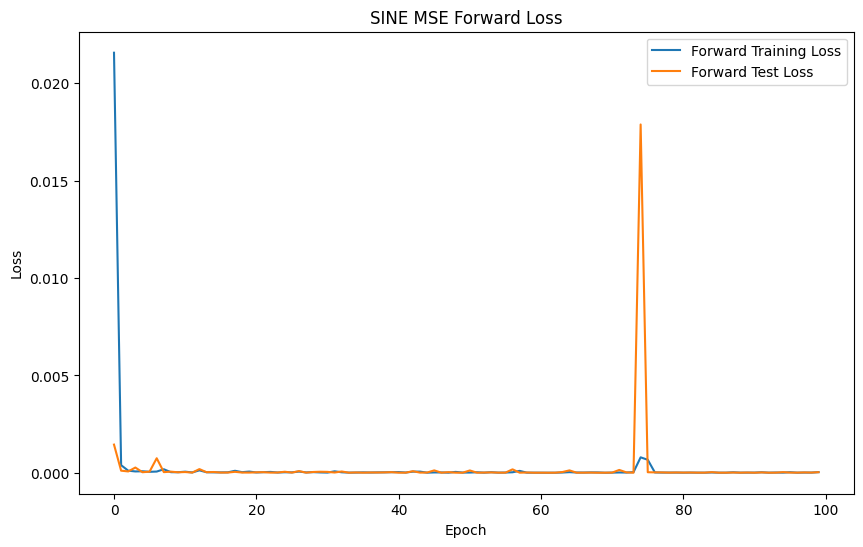

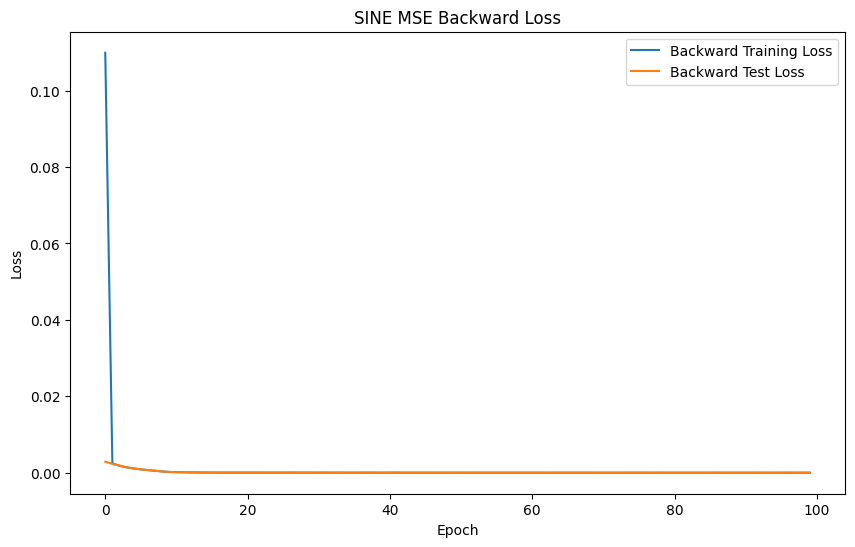

In [330]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("Running on GPU")
else: print("Running on CPU")

criterion = nn.MSELoss()
num_epochs = 100

# Forward Model Initialization and Training 
model_fwd = SimpleRNN(input_size=2, hidden_size=20, output_size=1).to(device)
optimizer_fwd = optim.Adam(model_fwd.parameters(), lr=0.01)

loss_values_fwd_train, loss_values_fwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer_fwd,
    criterion=criterion,
    model=model_fwd,
    train_loader=train_loader_fwd,
    test_loader=test_loader_fwd
              )

# Backward Model Initialization and Training
model_bkwd = SimpleRNN(input_size=2, hidden_size=20, output_size=1).to(device)
optimizer_bkwd = optim.Adam(model_bkwd.parameters(), lr=0.001)

loss_values_bkwd_train, loss_values_bkwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer_bkwd,
    criterion=criterion,
    model=model_bkwd,
    train_loader=train_loader_bkwd,
    test_loader=test_loader_bkwd
              )

plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd_train, label='Forward Training Loss')
plt.plot(loss_values_fwd_test, label='Forward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SINE MSE Forward Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(loss_values_bkwd_train, label='Backward Training Loss')
plt.plot(loss_values_bkwd_test, label='Backward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SINE MSE Backward Loss')
plt.legend()
plt.show()